# Metagraph and Metapath Generation

Here, we use the same syntax as [HetNetPy](https://github.com/hetio/hetnetpy/tree/e1ff1f8296b766dd5a63e5870a8a1a7d82427a80) to create a metagraph and extract metapaths from the KG.

Metagraph creation is based on [this notebook](https://github.com/dhimmel/integrate/blob/93feba1765fbcd76fd79e22f25121f5399629148/integrate.ipynb).

In [1]:
import pandas as pd
import seaborn as sns
import os.path as osp

import hetnetpy.hetnet
import hetnetpy.readwrite
import hetnetpy.stats

from hetnetpy.abbreviation import metaedges_from_metapath
from hetnetpy.pathtools import DWPC, paths_between

import re
import json
import tqdm
from collections import Counter

from itertools import chain

%matplotlib inline

## Using the protein subclasses

In this version of the KG, we subclassed some of the proteins to UniProt keywords. Since we need letters representing these subclasses, we'll assign that here.

In [2]:
MAPPING_DIR = '../data/mappings/'
METAPATHS_DIR = osp.join('../data', 'metapaths')

In [3]:
# Read in the json file containing the classes:
with open(osp.join(MAPPING_DIR, 'node2class.json'), 'r') as f:
    prot_classes = json.load(f)

prot_classes = {kw for keyword in prot_classes.values() for kw in keyword}

prot_classes = sorted(list(prot_classes))  # sort so we get consistent results each time code is run:

Be sure to exclude C and G because we've already assigned them to Compound and Gene.

In [4]:
# for each item in keep_kws, assign a letter of the alphabet in a dictionary, excluding C or G
class2letter = dict() 
i = 0
for kw in prot_classes:
    if kw == 'Gene':
        continue
    if chr(i + 65) in {'C', 'G'}:
        i += 1
    class2letter[kw] = chr(i + 65)
    i += 1

class2letter

{'DNA-binding': 'A',
 'Developmental protein': 'B',
 'Growth factor': 'D',
 'Hormone': 'E',
 'Hydrolase': 'F',
 'Oxidoreductase': 'H',
 'RNA-binding': 'I',
 'Receptor': 'J',
 'Repressor': 'K',
 'Transferase': 'L'}

In [5]:
KG_DIR = '../data/kg/'
SPLITS_DIR = osp.join(KG_DIR, 'splits')
POLO_DIR = osp.join(SPLITS_DIR, 'PoLo')

kg = pd.read_csv(osp.join(SPLITS_DIR, 'kg_no_cmp_bp.tsv'), sep='\t')

In [6]:
# show me the duplicated rows in the dataframe
kg[kg.duplicated(keep=False)]

,source,source_node_type,target,target_node_type,edge_type


### Define and Instantiate Metagraph:

In [7]:
kind_to_abbev = {
    
    # metanodes
    'Compound': 'C',
    'Gene': 'G',
    'Biological Process': 'BP',
    
    # metaedges
    'upregulates': 'u',
    'downregulates': 'd',
    'interacts': 'i',
    'participates': 'p',
    'induces': 't',
}

# add the new protein subclasses to the abbreviations:
kind_to_abbev.update(class2letter)

In [8]:
metaedge_tuples = list({(row['source_node_type'], row['target_node_type'], row['edge_type'], 'forward') for i, row in kg.iterrows()})

In [9]:
# now make the metagraph
metagraph = hetnetpy.hetnet.MetaGraph.from_edge_tuples(metaedge_tuples, kind_to_abbev)
graph = hetnetpy.hetnet.Graph(metagraph)

In [10]:
seen = set()

for i, row in kg.iterrows():
    if not (row['source'], row['source_node_type']) in seen:
        graph.add_node(kind=row['source_node_type'], identifier=row['source'])
        seen.add((row['source'], row['source_node_type']))
    if not (row['target'], row['target_node_type']) in seen:
        graph.add_node(kind=row['target_node_type'], identifier=row['target'])
        seen.add((row['target'], row['target_node_type']))

    src_id = row['source_node_type'], row['source']
    trgt_id = row['target_node_type'], row['target']

    graph.add_edge(source_id=src_id, target_id=trgt_id, kind=row['edge_type'], direction='forward')

## Network Visualization and Stats

In [11]:
metanode_df = hetnetpy.stats.get_metanode_df(graph)
metanode_df

,metanode,abbreviation,metaedges,nodes,unconnected_nodes
12,Biological Process,BP,11,86,0
0,Compound,C,22,300,0
3,DNA-binding,A,24,1064,0
9,Developmental protein,B,24,497,0
1,Gene,G,24,1694,0
10,Growth factor,D,24,109,0
6,Hormone,E,24,73,0
4,Hydrolase,F,24,938,0
7,Oxidoreductase,H,24,391,0
11,RNA-binding,I,24,382,0


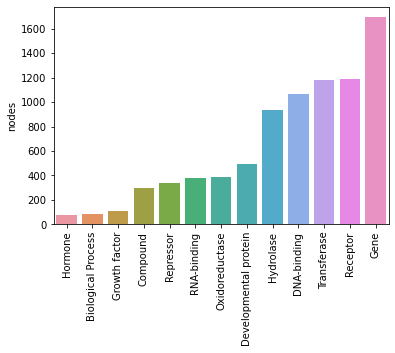

In [12]:
ax = sns.barplot(x='metanode', y='nodes', data=metanode_df.sort_values('nodes'))
for tick in ax.get_xticklabels():
    tick.set_rotation(90)
ax.set_xlabel(''); ax.set_ylabel('nodes');

In [13]:
# Total number of nodes
metanode_df.nodes.sum()

8241

In [14]:
# Summary of metaedges and cooresponding edges
metaedge_df = hetnetpy.stats.get_metaedge_df(graph)

In [15]:
metaedge_df.sort_values('edges', ascending=True).head(50)

,metaedge,abbreviation,edges,source_nodes,target_nodes
29,Growth factor > interacts > RNA-binding,Di>I,2,2,2
108,Oxidoreductase > interacts > Hormone,Hi>E,6,6,6
124,RNA-binding > interacts > Hormone,Ii>E,7,3,7
102,Oxidoreductase > interacts > RNA-binding,Hi>I,7,7,7
89,Growth factor > interacts > Oxidoreductase,Di>H,11,6,11
121,RNA-binding > interacts > Growth factor,Ii>D,12,9,9
49,Oxidoreductase > interacts > Growth factor,Hi>D,13,8,11
123,Hydrolase > interacts > Hormone,Fi>E,18,17,15
34,Oxidoreductase > interacts > Developmental pro...,Hi>B,19,18,19
64,Compound > downregulates > RNA-binding,Cd>I,19,17,10


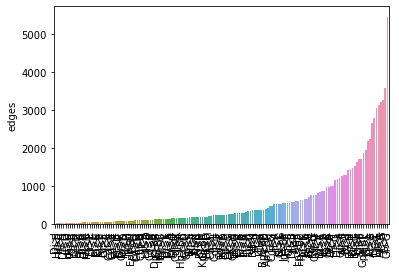

In [16]:
ax = sns.barplot(x='abbreviation', y='edges', data=metaedge_df.sort_values('edges'))
for tick in ax.get_xticklabels():
    tick.set_rotation(90)
ax.set_xlabel(''); ax.set_ylabel('edges');

# change dimensions of plot to be wider
#sns.set(rc={'figure.figsize':(100, 10)})

In [17]:
# Summary of different styles for representing each metaedge
metaedge_style_df = hetnetpy.stats.get_metaedge_style_df(metagraph)
metaedge_style_df.head()

,metaedge,unicode_metaedge,standard_metaedge,abbreviation,standard_abbreviation,source,target,inverted
285,Biological Process < participates < DNA-binding,Biological Process←participates←DNA-binding,DNA-binding > participates > Biological Process,BP<pA,ApBP,Biological Process,DNA-binding,1
21,Biological Process < participates < Developmen...,Biological Process←participates←Developmental ...,Developmental protein > participates > Biologi...,BP<pB,BpBP,Biological Process,Developmental protein,1
65,Biological Process < participates < Gene,Biological Process←participates←Gene,Gene > participates > Biological Process,BP<pG,GpBP,Biological Process,Gene,1
115,Biological Process < participates < Growth factor,Biological Process←participates←Growth factor,Growth factor > participates > Biological Process,BP<pD,DpBP,Biological Process,Growth factor,1
269,Biological Process < participates < Hormone,Biological Process←participates←Hormone,Hormone > participates > Biological Process,BP<pE,EpBP,Biological Process,Hormone,1


In [18]:
# Number of edges in the network
metaedge_df.edges.sum()

88079

## Metapath Extraction

Here, we have functions which can extract metapaths:

Extract metapaths from a given source node type (and, optionally, to a target node type):

In [19]:
tgt_metapaths = metagraph.extract_metapaths(source='Compound', target='Biological Process', max_length=4)
# print(tgt_metapaths)

We do not want any with a compound in the middle:

In [20]:
CtoBP_metapaths = []


for i in tgt_metapaths:
    if (repr(i) != 'Ct>BP') & (Counter(re.split('>|<|[^A-Z]', repr(i)))['C'] == 1):
        CtoBP_metapaths.append(i)

How many did it prune?

In [21]:
print(len(CtoBP_metapaths))
print(len(tgt_metapaths))

11396
12364


## Metapaths Between Training, Validation, Testing

Here, we'll look at the metapaths that occur between each of the sets of drug-BP pairs.

In [22]:
def get_paths(
    graph,
    source,
    target,
    rule,
):
    try:
        paths = paths_between(
            graph,
            source=('Compound', source),
            target=('Biological Process', target),
            metapath=tuple(rule),
            duplicates=False,
        )
    except Exception as e:
        print(e)
        paths = []        
    
    return paths

In [23]:
# read in train.txt, test.txt, and dev.txt from POLO_DIR
train = pd.read_csv(osp.join(SPLITS_DIR, 'train.tsv'), sep='\t')
test = pd.read_csv(osp.join(SPLITS_DIR, 'test.tsv'), sep='\t')
dev = pd.read_csv(osp.join(SPLITS_DIR, 'dev.tsv'), sep='\t')

# for each, get a set of the source and target columns
train = {(row['source'], row['target']) for i, row in train.iterrows()}
test = {(row['source'], row['target']) for i, row in test.iterrows()}
dev = {(row['source'], row['target']) for i, row in dev.iterrows()}

In [24]:
def get_metapath_counts(drug_BP_pairs):

    metapath_dict = {str(mpath): 0 for mpath in CtoBP_metapaths}

    for source, bp in tqdm.tqdm(drug_BP_pairs):
        # All metapaths going from compound to biological process
        for mpath in CtoBP_metapaths:
                    
            paths = get_paths(
                graph=graph,
                source=source,
                target=bp,
                rule=mpath,
            )
            
            if not paths:
                continue
                
            metapath_dict[str(mpath)] += len(paths)

    return metapath_dict

This next step is really long, which is why I've made it possible to skip if the files already exist:

In [25]:
# check if a file exists
if not osp.exists(osp.join(METAPATHS_DIR, 'train_metapaths.json')):
    train_metapaths = get_metapath_counts(train)
    with open(osp.join(METAPATHS_DIR, 'train_metapaths.json'), 'w') as f:
        json.dump(train_metapaths, f)

else:
    with open(osp.join(METAPATHS_DIR, 'train_metapaths.json'), 'r') as f:
        train_metapaths = json.load(f)

if not osp.exists(osp.join(METAPATHS_DIR, 'test_metapaths.json')):       
    test_metapaths = get_metapath_counts(test)
    with open(osp.join(METAPATHS_DIR, 'test_metapaths.json'), 'w') as f:
        json.dump(test_metapaths, f)

else:
    with open(osp.join(METAPATHS_DIR, 'test_metapaths.json'), 'r') as f:
        test_metapaths = json.load(f)

if not osp.exists(osp.join(METAPATHS_DIR, 'dev_metapaths.json')): 
    dev_metapaths = get_metapath_counts(dev)
    with open(osp.join(METAPATHS_DIR, 'dev_metapaths.json'), 'w') as f:
        json.dump(dev_metapaths, f)

else:
    with open(osp.join(METAPATHS_DIR, 'dev_metapaths.json'), 'r') as f:
        dev_metapaths = json.load(f)

In [26]:
# for each value, turn it into a ratio of value/ sum of all values
test_ratios = {k: v/sum(test_metapaths.values()) for k, v in test_metapaths.items()}
train_ratios = {k: v/sum(train_metapaths.values()) for k, v in train_metapaths.items()}
dev_ratios = {k: v/sum(dev_metapaths.values()) for k, v in dev_metapaths.items()}

In [27]:
# get any keys where the value is zero
zero_train = {k: v for k, v in train_ratios.items() if v == 0}
zero_test = {k: v for k, v in test_ratios.items() if v == 0}

In [28]:
len(set(zero_test.keys()))

2332

In [29]:
len(set(zero_train.keys()))

1349

Are there metapaths with zero instances in the training set but instances in the test set?

In [30]:
# nonzero keys in test
nonzero_test = {k: v for k, v in test_ratios.items() if v != 0}

In [31]:
len(set(zero_train.keys()) - set(nonzero_test.keys()))

1214

In [32]:
len(set(zero_train.keys()) - set(zero_test.keys()))

135

Are the most common keys mostly the same?

In [33]:
top_test = {tup[0] for tup in Counter(test_ratios).most_common(100)}
top_train = {tup[0] for tup in Counter(train_ratios).most_common(100)}

In [34]:
len(top_test & top_train) / len(top_test)

0.7

It seems they are mostly the same, but not exactly.

# PoLo Input Preparation

What if we want to get these in a format similar to the PoLo output?

First let's give them all a uniform probability:

In [35]:
#prob = 1 / (2 * len(CtoBP_metapaths))
prob = 0.5

We can split the metapaths into a series of individual relations:

In [36]:
def get_forward_rule_body(mpath, conf, metagraph):
    """Gets the rule body for a given metapath in the format that PoLo requires
        :param mpath: the metapath instance, written in hetnetpy format
        :param conf: the confidence value to use for the rule
        :param metagraph: the metagraph instance, as a hetnetpy object
    """
    st_edges = metaedges_from_metapath(mpath, standardize_by=metagraph)
    directional_edges = metaedges_from_metapath(mpath)
    rule_head = re.split('>|<|[^A-Z]', mpath)
    rule_head = rule_head[0] + 't' + rule_head[-1]
    rule_body = [conf, rule_head]
    for st, dic in zip(st_edges, directional_edges):
        if '>' in dic:
            rule_body.append(st)
        else:
            rule_body.append('_' + st)
    return rule_body

In [37]:
# just testing the function
get_forward_rule_body('Cu>G<uCd>Gp>BP', prob, metagraph)

[0.5, 'CtBP', 'CuG', '_CuG', 'CdG', 'GpBP']

In [38]:
def get_reverse_rule_body(forward_body):
    """Gets the REVERSE rule body for a given metapath in the format that PoLo requires
        :param forward_body: the forward rule body as a list
    """
    rev_body = [forward_body[0], '_' + forward_body[1]]
    for i in reversed(forward_body[2:]):
        if '_' in i:
            rev_body.append(re.sub('_', '', i))
        else:
            rev_body.append('_' + i)
    return rev_body

In [39]:
fw = get_forward_rule_body('Cu>G<uCd>Gp>BP', prob, metagraph)
get_reverse_rule_body(fw)

[0.5, '_CtBP', '_GpBP', '_CdG', 'CuG', '_CuG']

Now we'll do it for all the compound to BP metapaths!

In [40]:
rules = {}
rules['CtBP'] = [get_forward_rule_body(str(mpath), prob, metagraph) for mpath in CtoBP_metapaths]
# rules['_CtBP'] = [get_reverse_rule_body(mpath) for mpath in rules['CtBP']]
# print(rules)

In [41]:
rules.keys()

dict_keys(['CtBP'])

Finally, the rules have different lengths. Let's make it so that the smaller ones could also be used as longer rules by using the padding token "NO_OP", which means that the agent has decided to stay at the node.

In [42]:
def expand_rule(rule):
    """Expands a rule by a length of 1 to another series of rules by putting NO_OP in every gap"""
    new_rules = []
    for i in range(2, len(rule)):
        if rule[i] != 'NO_OP':
            new_rule = rule[0:i] + ['NO_OP'] + rule[i:]
            new_rules.append(new_rule)
    new_rules.append(rule + ['NO_OP'])
    return new_rules


In [43]:
expand_rule([0.5, 'CtBP', 'CdG', 'GpBP'])

[[0.5, 'CtBP', 'NO_OP', 'CdG', 'GpBP'],
 [0.5, 'CtBP', 'CdG', 'NO_OP', 'GpBP'],
 [0.5, 'CtBP', 'CdG', 'GpBP', 'NO_OP']]

In [44]:
expand_rule([0.5, 'CtBP', 'CuG', 'GpBP', 'NO_OP'])

[[0.5, 'CtBP', 'NO_OP', 'CuG', 'GpBP', 'NO_OP'],
 [0.5, 'CtBP', 'CuG', 'NO_OP', 'GpBP', 'NO_OP'],
 [0.5, 'CtBP', 'CuG', 'GpBP', 'NO_OP', 'NO_OP']]

In [45]:
expand_rule([0.5, 'CtBP', 'CuG', 'NO_OP', 'GpBP'])

[[0.5, 'CtBP', 'NO_OP', 'CuG', 'NO_OP', 'GpBP'],
 [0.5, 'CtBP', 'CuG', 'NO_OP', 'NO_OP', 'GpBP'],
 [0.5, 'CtBP', 'CuG', 'NO_OP', 'GpBP', 'NO_OP']]

In [46]:
for key in rules.keys():
    for path in rules[key]:
        if len(path) - 2 == 2:
            rules[key].extend(expand_rule(path))

for key in rules.keys():
    for path in rules[key]:
        if len(path) - 2 == 3:
            rules[key].extend(expand_rule(path))

Let's write it to a file we can use for PoLo:

In [47]:
with open(osp.join(POLO_DIR, 'rules.txt'), 'w') as f:
    json.dump(rules, f)

Now, let's get the input triples in a format consistent with PoLo's input files:

In [48]:
def convert_to_polo(df):
    """Converts the KG into a format that PoLo can use
    """
    df['metaedge'] = [kind_to_abbev[row['source_node_type']] + kind_to_abbev[row['edge_type']] + \
                       kind_to_abbev[row['target_node_type']] for i, row in df.iterrows()]
    return df[['source', 'metaedge', 'target']]

In [49]:
train = convert_to_polo(pd.read_csv(osp.join(SPLITS_DIR, 'train.tsv'), sep='\t'))
test = convert_to_polo(pd.read_csv(osp.join(SPLITS_DIR, 'test.tsv'), sep='\t'))
val = convert_to_polo(pd.read_csv(osp.join(SPLITS_DIR, 'dev.tsv'), sep='\t'))

kg_triples = convert_to_polo(pd.read_csv(osp.join(SPLITS_DIR, 'kg_with_train_smpls.tsv'), sep='\t'))

In [50]:
kg_triples.head()

,source,metaedge,target
0,ncbigene:330,LiL,ncbigene:7187
1,ncbigene:23098,FpBP,GO:0030154
2,ncbigene:6885,LiG,ncbigene:51422
3,ncbigene:861,KiF,ncbigene:192669
4,ncbigene:3586,GiD,ncbigene:3592


Get the inverse triples of the KG:

In [51]:
inverse_triples = kg_triples[['source', 'target', 'metaedge']].copy()
inverse_triples['inv_metaedge'] = ['_' + i for i in inverse_triples['metaedge']]
inverse_triples = inverse_triples[['target', 'inv_metaedge', 'source']]

# get rid of those with _CtBP
inverse_triples = inverse_triples.loc[inverse_triples['inv_metaedge'] != '_CtBP']

Great, write to the PoLo folder:

In [52]:
kg_triples.to_csv(osp.join(POLO_DIR, 'graph_triples.txt'), sep='\t', index=False, header=False)
inverse_triples.to_csv(osp.join(POLO_DIR, 'graph_inverses.txt'), sep='\t', index=False, header=False)

In [53]:
train.to_csv(osp.join(POLO_DIR, 'train.txt'), sep='\t', index=False, header=False)
test.to_csv(osp.join(POLO_DIR, 'test.txt'), sep='\t', index=False, header=False)
val.to_csv(osp.join(POLO_DIR, 'dev.txt'), sep='\t', index=False, header=False)

Finally, we need dictionaries to map the entities and relations to unique IDs.

In [54]:
entities = {"PAD": 0, "UNK": 1}

next_id = 2
for df in kg_triples, train, test, val:
    for i in df['source'].unique():
        if i not in entities:
            entities[i] = next_id
            next_id += 1
    for i in df['target'].unique():
        if i not in entities:
            entities[i] = next_id
            next_id += 1

In [55]:
relations = {"PAD": 0, "DUMMY_START_RELATION": 1, "NO_OP": 2, "UNK": 3}

metaedges = set(kg_triples['metaedge']) | (set(inverse_triples['inv_metaedge']))

next_id = 4
for rel in metaedges:
    relations[rel] = next_id
    next_id += 1

In [56]:
# write dictionary to json file
with open(osp.join(POLO_DIR, 'entity_vocab.json'), 'w') as f:
    json.dump(entities, f)

with open(osp.join(POLO_DIR, 'relation_vocab.json'), 'w') as f:
    json.dump(relations, f)